# BPS Bus Route Optimization

### Problem Statement
The Boston Public Schools has released an RFP seeking to find a solution to optimize their strategy for student transportation to and from school. 

From BPS: "In [2016], transportation costs accounted for \$110 million or 11% of the district’s budget. On a per pupil basis, BPS’s transportation cost is the second highest and more than five times the average of the largest 200 public school districts."

In order to make their transporation network more efficient and potentially less costly, BPS has posed the following two challenges.

#### Step 1: Optimize Bus Stop Locations 

We are working to consolidate bus stops to increase efficiency and decrease student ride time, while also ensuring that students are able to walk safely and quickly to a nearby bus stop. Based on where students live, their destination schools, and the type of service required (i.e. Corner Stop, Door to Door, Wheelchair) how will you assign students to a stop?

#### Step 2: Improve Routing Efficiencies

We are working to get all students to school as quickly as possible in time for the start of the day. Given the location of bus stops, how would you connect these stops to schools over the course of a day creating a full route for a bus that starts and ends at a given bus yard? How will you account for different types of services required (Corner Stop, Door to Door, Wheelchair)?"



### Outcome
The expected outcome of this project is a modeled system of a minimized number of bus stops and routes that provide efficient transportation for every student to and from school. The system will be measured by comparison to the baseline of the existing BPS transportation system as described below:

Scenario | # of required busses |Service hours | Service miles
---| ---| ---
current BPS system | 630 | 3,600 | 44,500

### Approach

1. Data Visualization and Exploration: I will start by visualizing the dsitribution of students across Boston using the mapping libraries
2. Bus Stop Optimization: I hypothesize that by reducing the number of bus stops, the number of service hours will reduce, creating a more efficient system. In order to model this, I will look to highly dense areas and students' maximum walking distance to see if any walking radii overlap. If a student's max walking distance overlaps with that of another student, there is a potential for stops to be combined.In order to measure this, I will need to compare my model's stop count to that of the current BPS system.
3. Once I have a list of optimized bus stops for each student, I will need to model the bus routes taken in order to serve each student. To model this, I will look to various algorithms to solve what is commonly known as the 'Traveling Salesman Problem
4. 

### The Data\*

BPS has made available a dataset capturing information for 90 schools and nearly 5000 students. The feautres included in the dataset are as follows:

Variable | Description | Type of Variable
---| ---| ---
Street Number | House number of student | continuous integer
Street Name |  Name of the street on which the student lives | categorical string
Zip Code | Zip Code in which the student lives | categorical integer 
Latitude | Geodetic coordinate system in decimal degrees | continuous float
Longitude | Geodetic coordinate system in decimal degrees | continuous float
Pickup Type | Corner or Door-to-Door | categorical string
Grade | Grade of the student | categorical integer
Geocode | BPS tracks various neighborhoods by census ‘geocodes’ which we use to analyze student neighborhoods | continuous integer
Neighborhood Safety Score | Based on amount of reported violent crime in neighborhood -- 7 = high level and 1 represents a low level | categorical integer
MaxWalk | Maximum distance student should walk to a stop. Actual walking distance along a common path. Each student will have specific max walking distance based on their grade and rates of reported crime within neighborhood | continuous float
Assigned School | School student is required to be transported to and from each day | categorical string
Current School Start | Arrive at school between 10-15 minutes before the start of school. While the bus needs to arrive 10-15 minutes before the start of school, the bus should plan to leave at the start of school. This allows time for buses to unload and builds in “recovery time” to account for unexpected delays on the route | time
Current School End | Time between school start time and school end time is the length of the school day for that school. Assume all students go home at the end of the day (i.e., they attend no after school activities). As detailed in Appendix 1: Rules of the Road buses should arrive by the school’s end time and leave no later than 15 minutes afterward | time
School Address | Full address of school | categorical string
School Lat | Geodetic coordinate system in decimal degrees | continuous float
School Long | Geodetic coordinate system in decimal degrees | continuous float


\* The data provided by BPS is not acutal student information. In order to protect students' safety and privay the data provided by the BPS is only representative of student information.

### Initial Setup and Package Import

In [1]:
from __future__ import print_function

import matplotlib.pyplot as plt
import matplotlib.cm
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
import sklearn as sk

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

/anaconda/envs/py27/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Load Data

Student Information

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/tylershannon/BPS-BusRouteOptimization/master/Data/BPS-StudentInformation.csv')

Bus Information

In [3]:
df_busyards = pd.read_csv('https://raw.githubusercontent.com/tylershannon/BPS-BusRouteOptimization/master/Data/BPS-BusYards.csv')

# 1 - Data Visualization and Exploration

Display data

In [4]:
df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867


Make new feature for flexability of stop location based on type of bus stop

In [5]:
df['StopFlex'] = 0.0

for i in range(len(df.PickupType)):
    if df.PickupType[i] == 'Corner':
        df.StopFlex[i] = df.MaxWalk[i]

In [6]:
df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong,StopFlex
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075,0.5
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084,0.4
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053,0.0
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552,0.4
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867,0.0


### Import vincenty which is a method for measuring on an oblate spheroid (earth)

In [7]:
from geopy.distance import vincenty

In [8]:
df2 = df.copy(deep=True)
df2 = df2[['Lat', 'Long','StopFlex']]

### Iterate through students and cluster into new bus stops based on each students allowable walking distance

In [9]:
df2['NewLat']= 'NaN'
df2['NewLong'] = 'NaN'
df2.head()

,Lat,Long,StopFlex,NewLat,NewLong
0,42.342049,-71.080765,0.5,NaN,NaN
1,42.317420,-71.094550,0.4,NaN,NaN
2,42.288240,-71.113130,0.0,NaN,NaN
3,42.271750,-71.161770,0.4,NaN,NaN
4,42.359400,-71.058700,0.0,NaN,NaN


In [10]:
r = len(df2) #range len(df2)
for i in range(r):
    if df2.NewLat[i] == 'NaN' and df2.StopFlex[i] == 0:
        base_coord = df2.Lat[i], df2.Long[i]
        for p in range(r):
            test_coord = df2.Lat[p], df2.Long[p]
            test_dist = vincenty(base_coord, test_coord).miles
            if test_dist <= df2.StopFlex[p]:
                df2.NewLat[p] = df2.Lat[i]
                df2.NewLong[p] = df2.Long[i]
for i in range(r):
    if df2.NewLat[i] == 'NaN':
        base_coord = df2.Lat[i], df2.Long[i]
        for p in range(r):
            test_coord = df2.Lat[p], df2.Long[p]
            test_dist = vincenty(base_coord, test_coord).miles
            if test_dist <= df2.StopFlex[p]:
                df2.NewLat[p] = df2.Lat[i]
                df2.NewLong[p] = df2.Long[i]
                
df2.head()

,Lat,Long,StopFlex,NewLat,NewLong
0,42.342049,-71.080765,0.5,42.3374,-71.0752
1,42.317420,-71.094550,0.4,42.3145,-71.0942
2,42.288240,-71.113130,0.0,42.2882,-71.1131
3,42.271750,-71.161770,0.4,42.2692,-71.1666
4,42.359400,-71.058700,0.0,42.3594,-71.0587


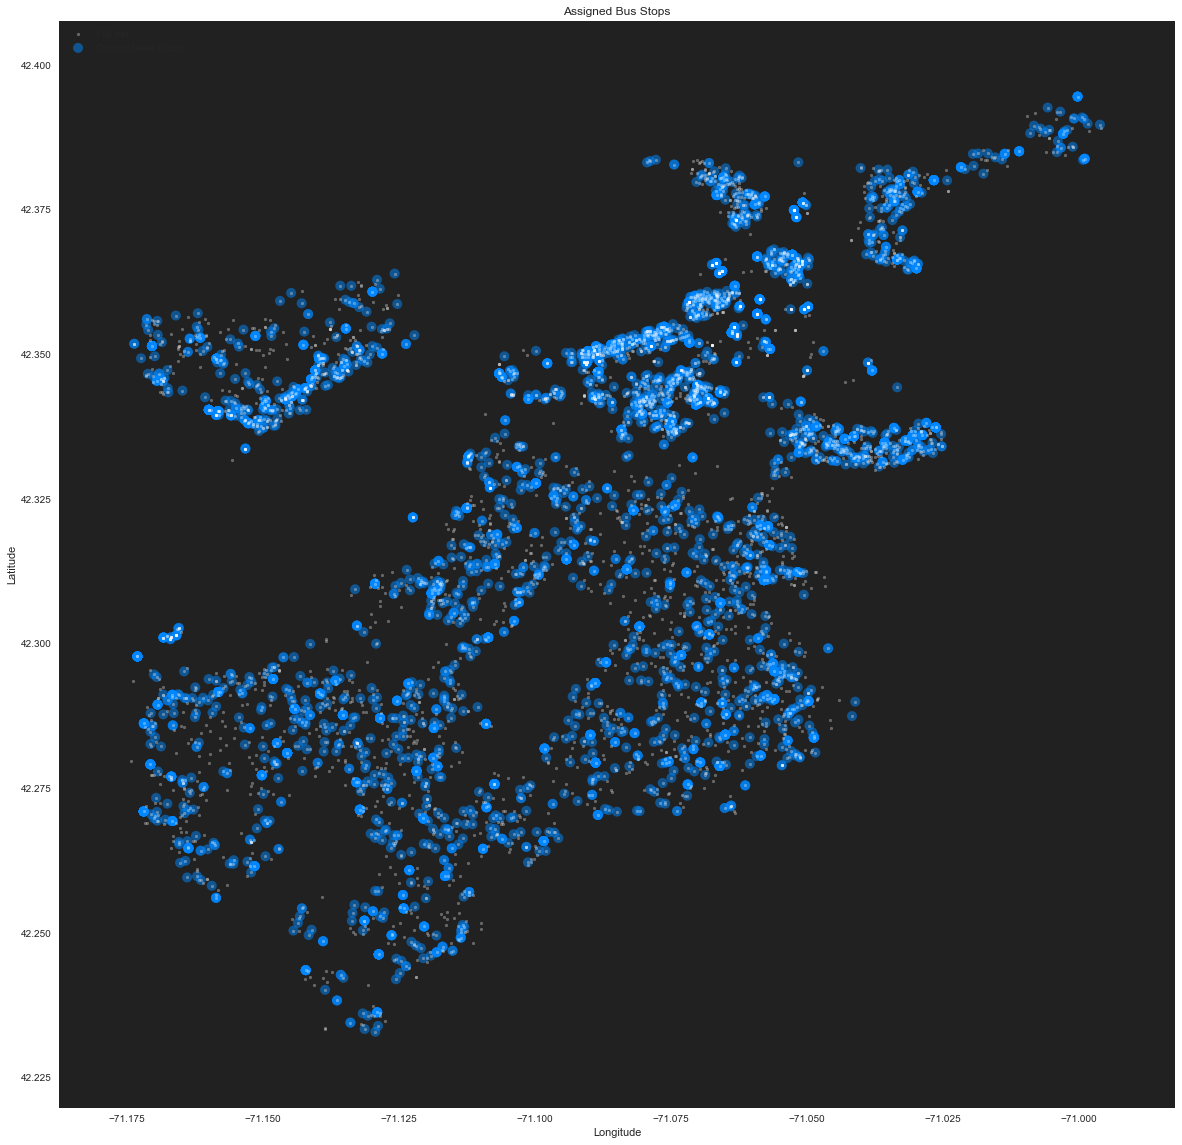

In [17]:
fig, ax = plt.subplots(figsize=[20, 20])

#plot optimized stops
opt_scatter = ax.scatter(df2['NewLong'], df2['NewLat'], c='#0087ff', edgecolor='None', alpha=0.5, s=100)

#plot full set
df_scatter = ax.scatter(df2['Long'], df2['Lat'], c='#ffffff', alpha=0.3, s=8)

#plot options
ax.set_title('Assigned Bus Stops')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, opt_scatter], ['Full set', 'Consolidated Stops'], loc='upper left')
ax.set_axis_bgcolor('#212121')
ax.grid(color = '#212121') #474747
plt.show()

In [18]:
df['NewLat']= df2.NewLat
df['NewLong'] = df2.NewLong
df.head()

,StreetNum,StreetName,ZipCode,Lat,Long,PickupType,Grade,Geocode,NeighborhoodSafetyScore,MaxWalk,AssignedSchool,CurrentSchoolStart,CurrentSchoolEnd,SchoolAddress,SchoolLat,SchoolLong,StopFlex,NewLat,NewLong
0,1,CLAREMONT PK,2118,42.342049,-71.080765,Corner,3,25025070800,3,0.5,Johnny Pesky School,8:30:00 AM,4:00:00 PM,"236 Beech St, 02131",42.281233,-71.141075,0.5,42.3374,-71.0752
1,1,DUNFORD ST,2119,42.317420,-71.094550,Corner,1,25025081500,5,0.4,Tris Speaker School,7:30:00 AM,2:10:00 PM,"40 Pershing Rd, 02130",42.318999,-71.114084,0.4,42.3145,-71.0942
2,1,ORGAN PARK ST,2131,42.288240,-71.113130,D2D,6,25025110301,4,0.5,John Gorman School,8:30:00 AM,4:00:00 PM,"110 Beachview Rd, 02128",42.391629,-71.005053,0.0,42.2882,-71.1131
3,2295,CENTRE ST,2132,42.271750,-71.161770,Corner,1,25025130402,2,0.4,Roger Clemens School,7:30:00 AM,3:00:00 PM,"200 Heath St, 02130",42.326009,-71.106552,0.4,42.2692,-71.1666
4,1,WESTINGHOUSE PZ,2136,42.359400,-71.058700,D2D,4,25025030300,7,0.3,Joe Dobson School,8:30:00 AM,4:00:00 PM,"61 School St, 02119",42.313946,-71.097867,0.0,42.3594,-71.0587


In [786]:
#df.to_csv('../Data/StopDataModified.csv')

In [19]:
df_busyards.head()

,Bus Number,Bus Yard,Bus Type,Bus Yard Address,Bus Yard Latitude,Bus Yard Longitude
0,B286,Frpt,Full,"2000 Washington Street, Boston, MA, 02119",42.333189,-71.080309
1,B287,Frpt,Full,"2000 Washington Street, Boston, MA, 02119",42.333189,-71.080309
2,B288,Frpt,Full,"2000 Washington Street, Boston, MA, 02119",42.333189,-71.080309
3,B289,Frpt,Full,"2000 Washington Street, Boston, MA, 02119",42.333189,-71.080309
4,B290,Frpt,Full,"2000 Washington Street, Boston, MA, 02119",42.333189,-71.080309


In [20]:
bus_yard_long = df_busyards['Bus Yard Longitude'].unique()
bus_yard_lat = df_busyards['Bus Yard Latitude'].unique()

### Visualize bus stop locations servicing one school

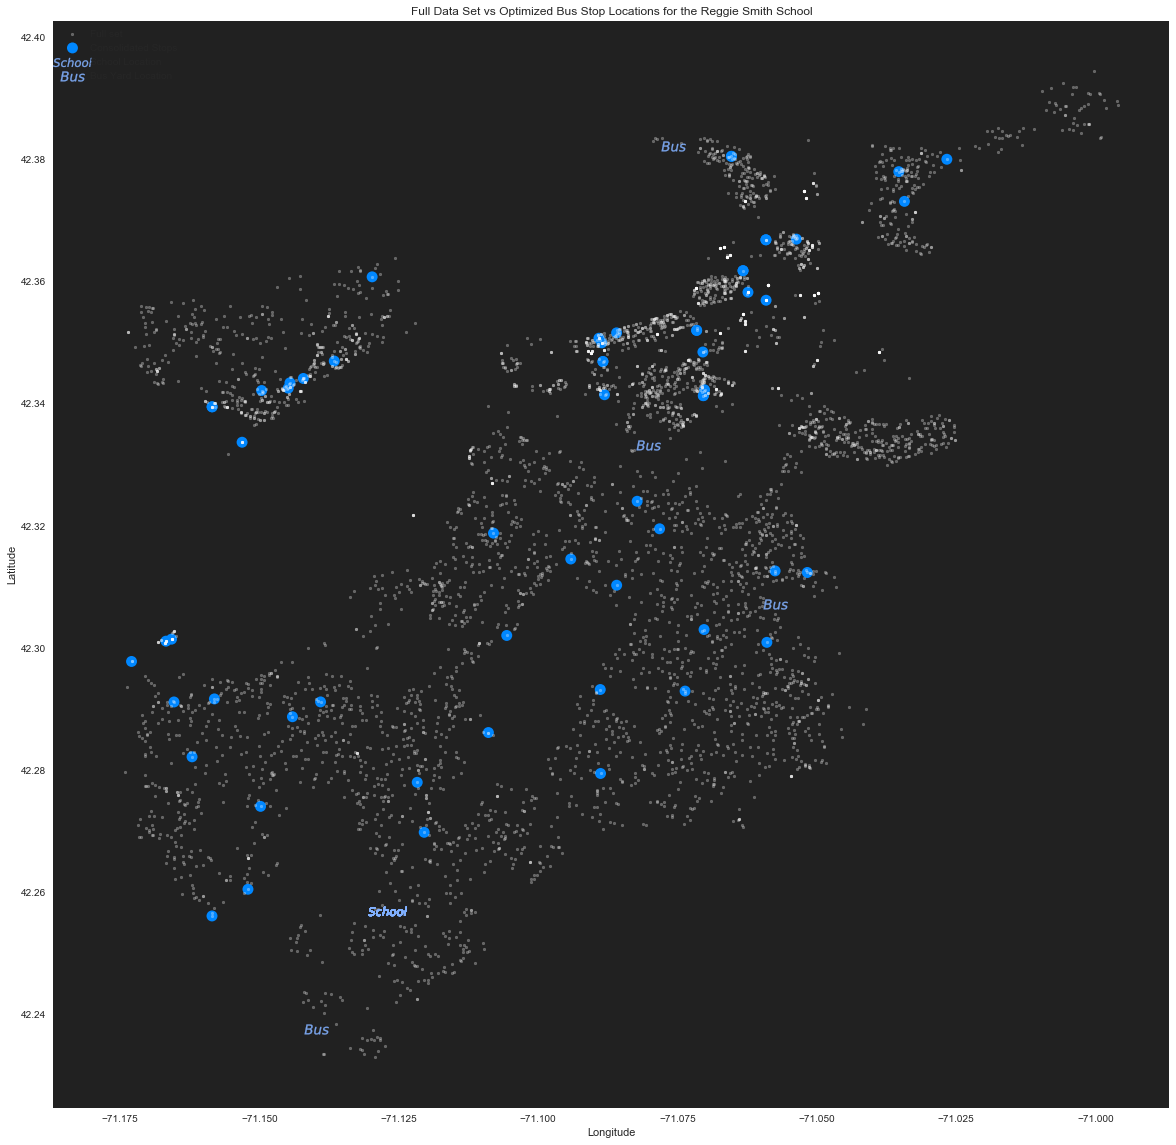

In [23]:
fig, ax = plt.subplots(figsize=[20, 20])

SchoolToShow = 'Reggie Smith School'

#plot optimized stops serving one school
opt_scatter = ax.scatter(df.loc[df['AssignedSchool'] == SchoolToShow].NewLong, 
                         df.loc[df['AssignedSchool'] == SchoolToShow].NewLat,
                         c='#0087ff', edgecolor='None', alpha=1, s=120)

#plot full set
df_scatter = ax.scatter(df2['Long'], df2['Lat'], c='#ffffff', alpha=0.3, s=8)

#plot location of bus yard location
bus_scatter = ax.scatter(bus_yard_long, 
                        bus_yard_lat,
                        c='#82b1ff', alpha=0.9, marker = '$Bus$', s=600)

#plot location of school
school_scatter = ax.scatter(df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong, 
                        df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat,
                        c='#82b1ff', alpha=0.9, marker = '$School$', s=1500)

#plot options
ax.set_title('Full Data Set vs Optimized Bus Stop Locations for the %s' %SchoolToShow)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, opt_scatter, school_scatter, bus_scatter], ['Full set', 'Consolidated Stops', 'School Location', 'Bus Yard Location'], loc='upper left')
ax.set_axis_bgcolor('#212121')
ax.grid(color = '#212121')
plt.show()

In [24]:
df_bus = df_busyards.copy(deep=True)
df_bus.drop_duplicates(subset = 'Bus Yard Address', inplace = True)
df_bus.drop(df_bus.columns[0:4], axis = 1, inplace = True)
df_bus.reset_index(inplace = True)
df_bus.drop(df_bus.columns[0], axis = 1, inplace = True)
df_bus

,Bus Yard Latitude,Bus Yard Longitude
0,42.333189,-71.080309
1,42.307069,-71.057577
2,42.237390,-71.139795
3,42.382205,-71.075801


# Traveling Salesman Problem

### Setup variables and node lists

### TSP - Traveling to stops sequentially through list

In [26]:

#-----------------------setup---------------------------
unchecked_nodes_lat = df.loc[df['AssignedSchool'] == SchoolToShow].NewLat.astype(float)
unchecked_nodes_long = df.loc[df['AssignedSchool'] == SchoolToShow].NewLong.astype(float)
index = unchecked_nodes_lat.index

#node list: 0 = index and 1 = latitude and 2 = longitude
unchecked_nodes = map(lambda i, a, b: [i, a, b], index, unchecked_nodes_lat, unchecked_nodes_long)
node_start = [0, df_bus['Bus Yard Latitude'][0], df_bus['Bus Yard Longitude'][0]]
node_end = [0, df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat[index[0]], df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong[index[0]]]
current_node = node_start
dist = 0.0
checked_nodes = []

#-----------------------test---------------------------

for i in range(len(unchecked_nodes)-1):
    while unchecked_nodes:
        base_coord = current_node[1], current_node[2]
        test_coord = unchecked_nodes[i][1], unchecked_nodes[i][2]
        dist = dist + vincenty(base_coord, test_coord).miles
        current_node = unchecked_nodes[i]
        checked_nodes.append(unchecked_nodes[i])
        unchecked_nodes.pop(i)
base_coord = checked_nodes[-1][1], checked_nodes[-1][2]
test_coord = node_end[1], node_end[2]
dist = dist + vincenty(base_coord, test_coord).miles
print('Route distance working sequentially through list of stops is %0.2f miles' %dist)           

Route distance working sequentially through list of stops is 230.26 miles


In [27]:
'''
random_tsp_route = pd.DataFrame(checked_nodes)
random_tsp_route.head()
random_tsp_route.to_csv('../Data/RandomRoute.csv')
'''

"\nrandom_tsp_route = pd.DataFrame(checked_nodes)\nrandom_tsp_route.head()\nrandom_tsp_route.to_csv('../Data/RandomRoute.csv')\n"

### TSP - Greedy Algorithm

In [ ]:
def nearest_node(base_node, nodes, radius = 10000, debug = False):
    closest_node = [0]
    for a in range(len(nodes)):
        base_coord = base_node[1], base_node[2]
        local_test = nodes[a][1], nodes[a][2]
        dist_test = vincenty(base_coord, local_test).miles
        if dist_test <= radius:
            radius = dist_test
            closest_node[0] = nodes[a]
    if debug == True:
        print(closest_node)
    return closest_node, radius    

In [30]:
#-----------------------setup---------------------------
unchecked_nodes_lat = df.loc[df['AssignedSchool'] == SchoolToShow].NewLat.astype(float)
unchecked_nodes_long = df.loc[df['AssignedSchool'] == SchoolToShow].NewLong.astype(float)
index = unchecked_nodes_lat.index

#node list: 0 = index and 1 = latitude and 2 = longitude
unchecked_nodes = map(lambda i, a, b: [i, a, b], index, unchecked_nodes_lat, unchecked_nodes_long)
node_start = [0, df_bus['Bus Yard Latitude'][0], df_bus['Bus Yard Longitude'][0]]
node_end = [0, df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat[index[0]], df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong[index[0]]]
current_node = node_start
dist = 0.0
checked_nodes = []
debug = False
#-----------------------test---------------------------


while unchecked_nodes:
    #nearest_node(current_node, unchecked_nodes) #this will return closet node to current node
    next_node, dist_next_node = nearest_node(current_node, unchecked_nodes)
    checked_nodes.append(next_node[0])
    current_node = next_node[0]
    next_node_index = unchecked_nodes.index(next_node[0])
    unchecked_nodes.pop(next_node_index)
    dist = dist + dist_next_node
    if debug == True:
        print('Unchecked Nodes', len(unchecked_nodes),
         'Checked Nodes', len(checked_nodes),
          dist, current_node)
print('Route distance using greedy algorithm is %0.2f miles' %dist)         

Route distance using greedy algorithm is 43.36 miles


In [808]:
'''
greedy_tsp_route = pd.DataFrame(checked_nodes)
greedy_tsp_route.head()
greedy_tsp_route.to_csv('../Data/GreedyRoute.csv')
'''

### TSP - Random Swap Algorithm

In [37]:
def seq_distance(nodes, debug = False):
    seq_dist = 0
    for a in range(len(nodes)-1):
        current_node = nodes[a]
        next_node = nodes[a+1]
        base_coord = current_node[1], current_node[2]
        local_test = next_node[1], next_node[2]
        dist_test = vincenty(base_coord, local_test).miles
        seq_dist = seq_dist + dist_test
    if debug == True:
        print(current_node)
    return seq_dist 

In [41]:
#-----------------------setup---------------------------
unchecked_nodes_lat = df.loc[df['AssignedSchool'] == SchoolToShow].NewLat.astype(float)
unchecked_nodes_long = df.loc[df['AssignedSchool'] == SchoolToShow].NewLong.astype(float)
index = unchecked_nodes_lat.index

#node list: 0 = index and 1 = latitude and 2 = longitude
unchecked_nodes = map(lambda i, a, b: [i, a, b], index, unchecked_nodes_lat, unchecked_nodes_long)
node_start = [0, df_bus['Bus Yard Latitude'][0], df_bus['Bus Yard Longitude'][0]]
node_end = [0, df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLat[index[0]], df.loc[df['AssignedSchool'] == SchoolToShow].SchoolLong[index[0]]]
current_node = node_start
#dist = 0.0
checked_nodes = []
debug = False
#-----------------------test---------------------------

In [55]:
rounds = 100
dist = seq_distance(unchecked_nodes)

from random import randint

while rounds > 0:
    test_list = unchecked_nodes
    index_a = randint(0,len(test_list))
    index_b = randint(0,len(test_list))
    test_list[index_a], test_list[index_b] = test_list[index_b], test_list[index_a]
    test_dist = seq_distance(test_list)
    distance_delta = dist - test_dist
    if test_dist < dist:
        dist = test_dist
        unchecked_nodes = test_list
    else:
        test_list[index_a], test_list[index_b] = test_list[index_b], test_list[index_a]
    rounds = rounds - 1
    print('indixes flipped:', index_a, index_b, 'distance delta:', distance_delta, 'total distance:' dist)
    

SyntaxError: invalid syntax (<ipython-input-55-6df74315e068>, line 19)